<a href="https://colab.research.google.com/github/langmusi/Predictive-Modeling/blob/main/Topic_dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bertopic
!pip install bertopic[visualization]

In [2]:
from bertopic import BERTopic

In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Reading Data

In [ ]:
df = pd.read_csv('/content/open_dmg_4.csv', sep = ';')   # open_dmg_subset_eventcode.csv  # open_dmg_2
print(df.shape)
df.head()

In [ ]:
df.loc[df.Text == '  ']
#df.loc[[2]]
#df['Text'].iloc[2]

In [ ]:
# removing empty string in Text-column
df = df.loc[df.Text != '  ']
df.shape
df

In [7]:
text = df['Text'].tolist()

### Checking Max Length of the Sentences

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('KB/electra-small-swedish-cased-generator')
max_len = 0

# For every sentence...
for sent in text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    
    # Update the minimum sentence length

print('Max sentence length: ', max_len)


Max sentence length:  158


# Topic Modeling

In [ ]:
#topic_model = BERTopic(embedding_model=model, calculate_probabilities=True, nr_topics="auto") 
#topic_model = BERTopic(embedding_model="KB/bert-base-swedish-cased", calculate_probabilities=True, nr_topics = 30) 
# model

# af-ai-center/bert-large-swedish-uncased
# KB/electra-small-swedish-cased-generator
bert_pretrained_model = ["KB/bert-base-swedish-cased", "af-ai-center/bert-large-swedish-uncased", "KB/electra-small-swedish-cased-generator"]
topic_model = BERTopic(embedding_model=bert_pretrained_model[0], calculate_probabilities=True, nr_topics=15) 

In [ ]:
topics, probs = topic_model.fit_transform(text)

In [ ]:
# Further reduce topics
new_topics, new_probs = topic_model.reduce_topics(text, topics, probabilities=probs, nr_topics=30)

In [ ]:
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} texts have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} texts are {topic_freq['Topic'].shape[0]-1} topics")

In [ ]:
topic_freq 

In [ ]:
df_sub_dat_eventcode = df.copy()
print(df_sub_dat_eventcode.shape)
# df_whole_dat.drop("Text", axis=1, inplace=True)
# df_whole_dat.shape

In [ ]:
#len(topics)
df_whole_dat['kb_sv_base_Topics'] = topics
#df_whole_dat.drop('Topics', axis=1, inplace=True)
df_whole_dat.head()

In [ ]:
df_sub_dat_eventcode.to_csv('./bert_topics_brakeSystem_subdat_eventcode_allmodels.csv',
                         decimal = ",", header = True, index = False, sep = ";", encoding = "utf-8-sig")

In [ ]:
df_sub_dat_eventcode['roberta_Topics'] = topics
#df_whole_dat.drop('Topics', axis=1, inplace=True)
df_sub_dat_eventcode.head()

# HDBSCAN - Cluster

### SentenceTransformers Sentence-embedding

In [ ]:
!pip install -U sentence-transformers

In [8]:
from sentence_transformers import SentenceTransformer

In [9]:
#topic_model = BERTopic(embedding_model=model, calculate_probabilities=True, nr_topics="auto") 
#topic_model = BERTopic(embedding_model="KB/bert-base-swedish-cased", calculate_probabilities=True, nr_topics = 30) 
# model

# af-ai-center/bert-large-swedish-uncased
# KB/electra-small-swedish-cased-generator

bert_pretrained_model = ["KB/bert-base-swedish-cased", "af-ai-center/bert-large-swedish-uncased", "KB/electra-small-swedish-cased-generator"]
model_st = SentenceTransformer(bert_pretrained_model[0], device='cuda')  # stsb-xlm-r-multilingual

Exception when trying to download http://sbert.net/models/KB/bert-base-swedish-cased.zip. Response 404
SentenceTransformer-Model http://sbert.net/models/KB/bert-base-swedish-cased.zip not found. Try to create it from scratch
Try to create Transformer Model KB/bert-base-swedish-cased with mean pooling


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# https://www.sbert.net/examples/applications/computing-embeddings/README.html
model_st.max_seq_length = 160

sentence_embeddings = model_st.encode(text, normalize_embeddings=True, show_progress_bar=True)
sentence_embeddings.shape
len(sentence_embeddings[0])

(779, 768)

768

In [ ]:
for sentence, embedding in zip(text[:2], sentence_embeddings[0:2]):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence:  Broms: EPAC 5, fastbromsningsskydd felaktigt 
Embedding: [ 0.03911424  0.03872656 -0.01046749 ...  0.01441973 -0.03359902
 -0.01162805]

Sentence:  Broms vagn A1: Avstängningskran för nödbroms stängd 
Embedding: [ 0.01069625  0.03592381 -0.02148718 ...  0.01310998 -0.0096124
 -0.03754138]



### Dimension Reduction

Why is dimensionality reduction always done before clustering? - https://stats.stackexchange.com/questions/256172/why-is-dimensionality-reduction-always-done-before-clustering

R: https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6: Graph-based clustering (Spectral, SNN-cliq, Seurat) is perhaps most robust for high-dimensional data as it uses the distance on a graph.

(From the same article as the above link shows)HDBSCAN, i.e. Hierarchical DBSCAN, is a powerful density-based clustering algorithm which is: 1) indifferent to the shape of clusters, 2) does not require the number of clusters to be specified, 3) robust with respect to clusters with different density. Further, HBDSCAN is very attractive because it has only one hyperparameter minPts which is the minimal number of points in a cluster. It is relatively fast for large data sets, detects outlying cells, and for each cell it reports a probability of assignment to a cluster.

One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding, t-SNE. - https://www.scikit-yb.org/en/latest/api/text/tsne.html

#### UMAP

Uniform Manifold Approximation and Projection for Dimension Reduction

In [11]:
import umap

In [12]:
# https://umap-learn.readthedocs.io/en/latest/sparse.html A text analysis example
reducer = umap.UMAP(metric='cosine', random_state=42)  # hellinger does not support negative values
reducer.fit(sentence_embeddings)

UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='cosine', metric_kwds=None,
     min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1, n_neighbors=15,
     negative_sample_rate=5, output_dens=False, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, ...)

In [13]:
umap_embedding = reducer.transform(sentence_embeddings)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(umap_embedding == reducer.embedding_))
umap_embedding.shape

(779, 2)

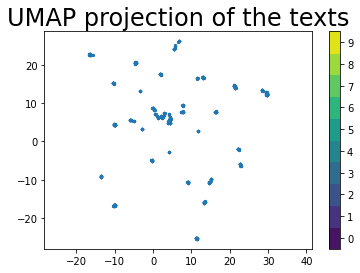

In [14]:
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1],cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the texts', fontsize=24);

## HDBSCAN

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

https://www.johnkraszewski.com/nlp
Two investigated algorithms were k-means clustering (Ball Tree) (22) and HDBSCAN (23). As shown in the following visualizations, the latter method was found to be much superior with regard to the cluster structure and consistency at the cost of higher complexity. Another benefit of the chosen algorithm was specifying outliers (cluster -1, dark grey).

In [15]:
import hdbscan
import sklearn.cluster as cluster
import time
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

#from sklearn.preprocessing import StandardScaler 

In [ ]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

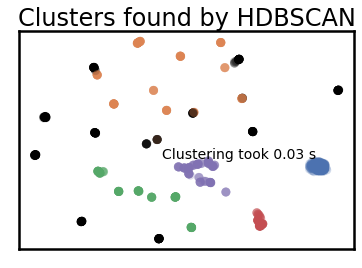

In [ ]:
plot_clusters(umap_embedding, hdbscan.HDBSCAN, (), {'min_cluster_size':50})

In [ ]:
plot_clusters(sentence_embeddings, hdbscan.HDBSCAN, (), {'min_cluster_size':50})

In [ ]:
plot_clusters(umap_embedding, cluster.SpectralClustering, (), {'n_clusters':6})

In [ ]:
plot_clusters(umap_embedding, cluster.DBSCAN, (), {'eps':5.25})

In [81]:
# min_samples: We can recover some of our original clusters by explicitly providing min_samples at the original value of 15.
# Increasing the min_cluster_size to 30 reduces the number of clusters, merging some together.
# The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas. 
# Leaf clustering: https://hdbscan.readthedocs.io/en/latest/parameter_selection.html
# A: https://hdbscan.readthedocs.io/en/latest/api.html

clusterer = hdbscan.HDBSCAN(min_cluster_size=20, 
                            #min_samples=15, 
                            #gen_min_span_tree=True, 
                            #cluster_selection_method='leaf',
                            metric='l2', #  If metric is “precomputed”, X is assumed to be a distance matrix and must be square. -A
                            allow_single_cluster=True)

clusterer.fit(umap_embedding)

### Searching Grid for min_cluster_size

In [90]:
for size in range(10, 40, 5):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
  labels = clusterer.fit_predict(umap_embedding)

  print((silhouette_score(umap_embedding, labels, metric='euclidean')))
  print((silhouette_score(umap_embedding, labels, metric='cosine')))

0.8047832
0.5779246
0.84333605
0.5586745
0.82479775
0.47003794
0.5964339
0.32251164
0.5024397
0.21886729
0.4119255
0.12319498


In [91]:
for size in range(10, 40, 5):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
  labels = clusterer.fit_predict(sentence_embeddings)

  print((silhouette_score(sentence_embeddings, labels, metric='euclidean')))
  print((silhouette_score(sentence_embeddings, labels, metric='cosine')))

0.6648234
0.63123477
0.5408453
0.53994334
0.49259168
0.5038326
0.43087435
0.43433386
0.2819711
0.26815537
0.24623413
0.22283866


In [ ]:
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
#cluster_colors
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_colors, **plot_kwds)

In [83]:
print(clusterer.labels_.max())

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)
print(n_clusters_)

n_noise_ = list(clusterer.labels_).count(-1)
print(n_noise_)

20
21
15


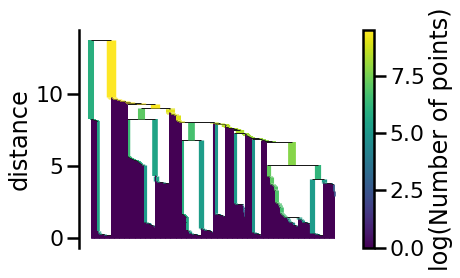

In [68]:
# building cluster hierarchy
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='leaf', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=30, min_samples=None, p=None,
        prediction_data=False)

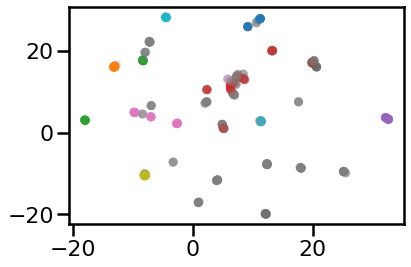

In [ ]:
clusterer.fit(sentence_embeddings)

palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
#cluster_colors
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_colors, **plot_kwds)

In [ ]:
clusterer.labels_.max()

9

### Silhouette Score

In [28]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [84]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
print(silhouette_score(umap_embedding, clusterer.labels_, metric='cosine'))
#print(silhouette_score(sentence_embeddings, clusterer.labels_, metric='cosine'))
print(silhouette_score(umap_embedding, clusterer.labels_, metric='euclidean'))
#silhouette_score(sentence_embeddings, clusterer.labels_, metric='euclidean')

0.47003794
0.82479775


In [ ]:
 # Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(umap_embedding, cluster_labels)

In [ ]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

In [ ]:
clusterer.labels_

array([ 1, -1,  0, ...,  0,  0,  0])

## Custom Function for All Models

In [93]:
def mycluster(text_list, bert_model, custom_mincluster_size, dimension_reduc_embedding = True, custom_max_seq_length = 160):
  
  # sentence embedding
  model_st = SentenceTransformer(bert_model, device='cuda') 
  model_st.max_seq_length = custom_max_seq_length
  sentence_embeddings = model_st.encode(text_list, normalize_embeddings=True, show_progress_bar=True)

  # dimension reduction
  reducer = umap.UMAP(random_state=42, metric='cosine')
  reducer.fit(sentence_embeddings)
  umap_embedding = reducer.transform(sentence_embeddings)

  # clustering HDBSCAN
  clusterer = hdbscan.HDBSCAN(min_cluster_size=custom_mincluster_size)
  
  if dimension_reduc_embedding == True:
    clusterer.fit(umap_embedding)
  else:
    clusterer.fit(sentence_embeddings)

  unique_value = np.unique(clusterer.labels_)

  return clusterer.labels_, unique_value


In [98]:
custom_min_cluster_size = 15

In [95]:
#topic_model = BERTopic(embedding_model="KB/bert-base-swedish-cased", calculate_probabilities=True, nr_topics = 30) 
# model

# af-ai-center/bert-large-swedish-uncased
# KB/electra-small-swedish-cased-generator

bert_pretrained_model = ["KB/bert-base-swedish-cased", "af-ai-center/bert-large-swedish-uncased", "KB/electra-small-swedish-cased-generator"]
bert_base_cluster, bert_base_unique_cluster = mycluster(text, bert_model=bert_pretrained_model[0],
                                       custom_mincluster_size = custom_min_cluster_size)
#elec_cluster
bert_base_unique_cluster

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [99]:
#topic_model = BERTopic(embedding_model="KB/bert-base-swedish-cased", calculate_probabilities=True, nr_topics = 30) 
# model

# af-ai-center/bert-large-swedish-uncased
# KB/electra-small-swedish-cased-generator

af_cluster, af_unique_cluster = mycluster(text, bert_model=bert_pretrained_model[1],
                                       custom_mincluster_size = custom_min_cluster_size)
#af_cluster
af_unique_cluster

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [100]:
elec_cluster, elec_unique_cluster = mycluster(text, bert_model=bert_pretrained_model[2],
                                                 custom_mincluster_size = custom_min_cluster_size)

elec_unique_cluster

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23])

In [ ]:
df['af_cluster'] = af_cluster
df['elec_cluster'] = elec_cluster
df['bert_base_cluster'] = bert_base_cluster
df

In [102]:
df.to_csv('./bert_topics_brakeSystem_models.csv',
          decimal = ",", header = True, index = False, sep = ";", encoding = "utf-8-sig")

In [ ]:
while True:pass